In [1]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "fashion-mnist_train.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zalando-research/fashionmnist",
  file_path,
)

/tmp/ipython-input-1251482784.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'fashionmnist' dataset.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, random_state=42)

xtrain = xtrain/255
xtest = xtest/255

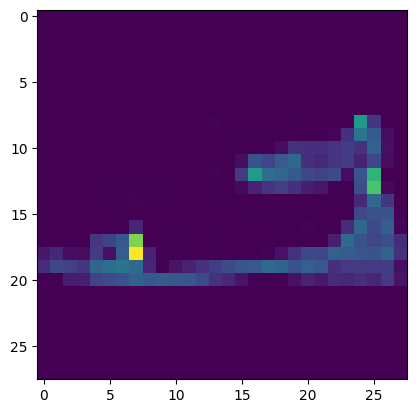

In [5]:
plt.imshow(xtrain.iloc[9, :].values.reshape(28,28))

In [8]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [10]:
traindataset = CustomDataset(xtrain.values, ytrain.values)

testdataset = CustomDataset(xtest.values, ytest.values)

In [11]:
traindataloader = DataLoader(traindataset, batch_size=100, shuffle=True, pin_memory=True)
testdataloader = DataLoader(testdataset, batch_size=100, shuffle=False, pin_memory=True)

In [13]:
class myCNN(nn.Module):

    def __init__(self, input_features):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(64, 10)

        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [15]:
learning_rate = 0.1
epochs = 100

model = myCNN(input_features=1) # 1 if black and white, 3 if rgb image

model.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(epochs):

    epoch_loss = 0

    for batch_features, batch_labels in traindataloader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        ypred = model(batch_features)

        loss = loss_function(ypred, batch_labels.long())

        epoch_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    print(f'epoch {epoch+1} -> loss {epoch_loss/(xtrain.shape[1]/100)}')

epoch 1 -> loss 33.17687065739717
epoch 2 -> loss 21.449553040901616
epoch 3 -> loss 18.55739994088606
epoch 4 -> loss 16.649173737066437
epoch 5 -> loss 15.268875928405597
epoch 6 -> loss 14.114199773579532
epoch 7 -> loss 12.867913260219657
epoch 8 -> loss 12.206347454909464
epoch 9 -> loss 11.454387292341918
epoch 10 -> loss 10.438093729317188
epoch 11 -> loss 10.247278844044374
epoch 12 -> loss 9.558312213333437
epoch 13 -> loss 9.010526707053794
epoch 14 -> loss 9.002784042315064
epoch 15 -> loss 8.309572304560975
epoch 16 -> loss 7.834218226952896
epoch 17 -> loss 7.365712842295821
epoch 18 -> loss 6.826829372154434
epoch 19 -> loss 6.7611684452514265
epoch 20 -> loss 6.56282462593054
epoch 21 -> loss 6.0540813533351665
epoch 22 -> loss 5.761771299401108
epoch 23 -> loss 5.612347214910373
epoch 24 -> loss 5.519247044837672
epoch 25 -> loss 5.34568762927012
epoch 26 -> loss 5.2350812225735615
epoch 27 -> loss 4.972222715388147
epoch 28 -> loss 4.5494263819466365
epoch 29 -> loss 4

In [16]:
model.eval() # helpful because certain part of NN, work differently during traing and prediction, like dropouts and batchnormalization


total = 0
correct = 0


with torch.no_grad():
    
    for batch_features, batch_labels in testdataloader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)

        prediction = torch.argmax(outputs, dim=1)

        total = total + batch_labels.shape[0]

        correct = correct + (prediction == batch_labels).sum().item()

    print(correct/total)

        

0.9242666666666667
